
<a id='data-statistical-packages'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Data and Statistics Packages

## Contents

- [Data and Statistics Packages](#Data-and-Statistics-Packages)  
  - [Overview](#Overview)  
  - [DataFrames](#DataFrames)  
  - [Statistics and Econometrics](#Statistics-and-Econometrics)  

## Overview

This lecture explores some of the key packages for working with data and doing statistics in Julia.

In particular, we will examine the `DataFrame` object in detail (i.e., construction, manipulation, querying, visualization, and nuances like missing data).

While Julia is not an ideal language for pure cookie-cutter statistical analysis, it has many useful packages to provide those tools as part of a more general solution.

This list is not exhaustive, and others can be found in organizations such as [JuliaStats](https://github.com/JuliaStats), [JuliaData](https://github.com/JuliaData/), and  [QueryVerse](https://github.com/queryverse).

### Setup

In [1]:
using InstantiateFromURL
# optionally add arguments to force installation: instantiate = true, precompile = true
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.8.0")

In [2]:
using LinearAlgebra, Statistics
using DataFrames, RDatasets, DataFramesMeta, CategoricalArrays, Query, VegaLite
using GLM

## DataFrames

A useful package for working with data is [DataFrames.jl](https://github.com/JuliaStats/DataFrames.jl).

The most important data type provided is a `DataFrame`, a two dimensional array for storing heterogeneous data.

Although data can be heterogeneous within a `DataFrame`, the contents of the columns must be homogeneous
(of the same type).

This is analogous to a `data.frame` in R, a `DataFrame` in Pandas (Python) or, more loosely, a spreadsheet in Excel.

There are a few different ways to create a DataFrame.

### Constructing and Accessing a DataFrame

The first is to set up columns and construct a dataframe by assigning names

In [3]:
using DataFrames, RDatasets  # RDatasets provides good standard data examples from R

# note use of missing
commodities = ["crude", "gas", "gold", "silver"]
last_price = [4.2, 11.3, 12.1, missing]
df = DataFrame(commod = commodities, price = last_price)

,commod,price
,String,Float64?
1,crude,4.2
2,gas,11.3
3,gold,12.1
4,silver,missing


Columns of the `DataFrame` can be accessed by name using `df.col`, as below

In [4]:
df.price

4-element Array{Union{Missing, Float64},1}:
  4.2
 11.3
 12.1
   missing

Note that the type of this array has values `Union{Missing, Float64}` since it was created with a `missing` value.

In [5]:
df.commod

4-element Array{String,1}:
 "crude"
 "gas"
 "gold"
 "silver"

The `DataFrames.jl` package provides a number of methods for acting on `DataFrame`’s, such as `describe`.

In [6]:
DataFrames.describe(df)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Union…,Type
1,commod,,crude,,silver,4,,String
2,price,9.2,4.2,11.3,12.1,,1,"Union{Missing, Float64}"


While often data will be generated all at once, or read from a file, you can add to a `DataFrame` by providing the key parameters.

In [7]:
nt = (commod = "nickel", price= 5.1)
push!(df, nt)

,commod,price
,String,Float64?
1,crude,4.2
2,gas,11.3
3,gold,12.1
4,silver,missing
5,nickel,5.1


Named tuples can also be used to construct a `DataFrame`, and have it properly deduce all types.

In [8]:
nt = (t = 1, col1 = 3.0)
df2 = DataFrame([nt])
push!(df2, (t=2, col1 = 4.0))

,t,col1
,Int64,Float64
1,1,3.0
2,2,4.0


In order to modify a column, access the mutating version by the symbol `df[!, :col]`.

In [9]:
df[!, :price]

5-element Array{Union{Missing, Float64},1}:
  4.2
 11.3
 12.1
   missing
  5.1

Which allows modifications, like other mutating `!` functions in julia.

In [10]:
df[!, :price] *= 2.0  # double prices

5-element Array{Union{Missing, Float64},1}:
  8.4
 22.6
 24.2
   missing
 10.2

As discussed in the next section, note that the [fundamental types](../getting_started_julia/fundamental_types.html#missing), is propagated, i.e. `missing * 2 === missing`.

### Working with Missing

As we discussed in [fundamental types](../getting_started_julia/fundamental_types.html#missing), the semantics of `missing` are that mathematical operations will not silently ignore it.

In order to allow `missing` in a column, you can create/load the `DataFrame`
from a source with `missing`’s, or call `allowmissing!` on a column.

In [11]:
allowmissing!(df2, :col1) # necessary to add in a for col1
push!(df2, (t=3, col1 = missing))
push!(df2, (t=4, col1 = 5.1))

,t,col1
,Int64,Float64?
1,1,3.0
2,2,4.0
3,3,missing
4,4,5.1


We can see the propagation of `missing` to caller functions, as well as a way to efficiently calculate with non-missing data.

In [12]:
@show mean(df2.col1)
@show mean(skipmissing(df2.col1))

mean(df2.col1) = missing
mean(skipmissing(df2.col1)) = 4.033333333333333


4.033333333333333

And to replace the `missing`

In [13]:
df2.col1  .= coalesce.(df2.col1, 0.0) # replace all missing with 0.0

4-element Array{Union{Missing, Float64},1}:
 3.0
 4.0
 0.0
 5.1

### Manipulating and Transforming DataFrames

One way to do an additional calculation with a `DataFrame` is to tuse the `@transform` macro from `DataFramesMeta.jl`.

In [14]:
using DataFramesMeta
f(x) = x^2
df2 = @transform(df2, col2 = f.(:col1))

,t,col1,col2
,Int64,Float64?,Float64
1,1,3.0,9.0
2,2,4.0,16.0
3,3,0.0,0.0
4,4,5.1,26.01


### Categorical Data

For data that is [categorical](https://juliadata.github.io/DataFrames.jl/stable/man/categorical/)

In [15]:
using CategoricalArrays
id = [1, 2, 3, 4]
y = ["old", "young", "young", "old"]
y = CategoricalArray(y)
df = DataFrame(id=id, y=y)

,id,y
,Int64,Cat…
1,1,old
2,2,young
3,3,young
4,4,old


In [16]:
levels(df.y)

2-element Array{String,1}:
 "old"
 "young"

### Visualization, Querying, and Plots

The `DataFrame` (and similar types that fulfill a standard generic interface) can fit into a variety of packages.

One set of them is the [QueryVerse](https://github.com/queryverse).

**Note:** The QueryVerse, in the same spirit as R’s tidyverse, makes heavy use of the pipeline syntax `|>`.

In [17]:
x = 3.0
f(x) = x^2
g(x) = log(x)

@show g(f(x))
@show x |> f |> g; # pipes nest function calls

g(f(x)) = 2.1972245773362196
(x |> f) |> g = 

2.1972245773362196


To give an example directly from the source of the LINQ inspired [Query.jl](http://www.queryverse.org/Query.jl/stable/)

In [18]:
using Query

df = DataFrame(name=["John", "Sally", "Kirk"], age=[23., 42., 59.], children=[3,5,2])

x = @from i in df begin
    @where i.age>50
    @select {i.name, i.children}
    @collect DataFrame
end

,name,children
,String,Int64
1,Kirk,2


While it is possible to just use the `Plots.jl` library, there may be better options for displaying tabular data – such as [VegaLite.jl](https://github.com/queryverse/VegaLite.jl).

WARN Missing type for channel "color", using "nominal" instead.


WARN Missing type for channel "color", using "nominal" instead.


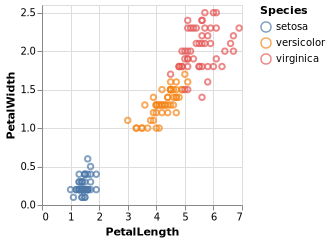

In [19]:
using RDatasets, VegaLite
iris = dataset("datasets", "iris")

iris |> @vlplot(
    :point,
    x=:PetalLength,
    y=:PetalWidth,
    color=:Species
)

## Statistics and Econometrics

While Julia is not intended as a replacement for R, Stata, and similar specialty languages, it has a growing number of packages aimed at statistics and econometrics.

Many of the packages live in the [JuliaStats organization](https://github.com/JuliaStats/).

A few to point out

- [StatsBase](https://github.com/JuliaStats/StatsBase.jl) has basic statistical functions such as geometric and harmonic means, auto-correlations, robust statistics, etc.  
- [StatsFuns](https://github.com/JuliaStats/StatsFuns.jl) has a variety of mathematical functions and constants such as pdf and cdf of many distributions, softmax, etc.  

### General Linear Models

To run linear regressions and similar statistics, use the [GLM](http://juliastats.github.io/GLM.jl/latest/) package.

In [20]:
using GLM

x = randn(100)
y = 0.9 .* x + 0.5 * rand(100)
df = DataFrame(x=x, y=y)
ols = lm(@formula(y ~ x), df) # R-style notation

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y ~ 1 + x

Coefficients:
──────────────────────────────────────────────────────────────────────────
             Estimate  Std. Error  t value  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  0.239083   0.0149413  16.0015    <1e-28   0.209432   0.268733
x            0.910987   0.0149344  60.9993    <1e-79   0.88135    0.940624
──────────────────────────────────────────────────────────────────────────

To display the results in a useful tables for LaTeX and the REPL, use
[RegressionTables](https://github.com/jmboehm/RegressionTables.jl/) for output
similar to the Stata package esttab and the R package stargazer.

In [21]:
using RegressionTables
regtable(ols)
# regtable(ols,  renderSettings = latexOutput()) # for LaTex output


----------------------
                  y   
              --------
                   (1)
----------------------
(Intercept)   0.239***
               (0.015)
x             0.911***
               (0.015)
----------------------
Estimator          OLS
----------------------
N                  100
R2               0.974
----------------------




### Fixed Effects

While Julia may be overkill for estimating a simple linear regression,
fixed-effects estimation with dummies for multiple variables are much more computationally intensive.

For a 2-way fixed-effect, taking the example directly from the documentation using [cigarette consumption data](https://github.com/johnmyleswhite/RDatasets.jl/blob/master/doc/plm/rst/Cigar.rst)

In [22]:
using FixedEffectModels
cigar = dataset("plm", "Cigar")
cigar.StateCategorical =  categorical(cigar.State)
cigar.YearCategorical =  categorical(cigar.Year)
fixedeffectresults = reg(cigar, @formula(Sales ~ NDI + fe(StateCategorical) + fe(YearCategorical)),
                            weights = :Pop, Vcov.cluster(:State))
regtable(fixedeffectresults)


----------------------------
                     Sales  
                   ---------
                         (1)
----------------------------
NDI                -0.005***
                     (0.001)
----------------------------
StateCategorical         Yes
YearCategorical          Yes
----------------------------
Estimator                OLS
----------------------------
N                      1,380
R2                     0.803
----------------------------


